# how does eccentricity change things?

Benjamin Pennell

--

Max Planck Institut für Astronomie, Heidelberg

---

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy.optimize import minimize
from scipy.stats import kstest, ks_2samp
import pickle
from scipy.interpolate import RegularGridInterpolator
import h5py
import matplotlib
import pandas as pd

from astropy.table import Table
from astroquery.gaia import Gaia
import Sampler

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import Sampler
sc_cubes_circular = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
sc_cubes_thermal = pickle.load(open("./data/2025-12-12-200pc_mdwarf_thermal_3plx.pkl", "rb"))
sc_cubes_turnover = pickle.load(open("./data/2025-12-12-200pc_mdwarf_turnover_3plx.pkl", "rb"))
t_loaded = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')

In [3]:
memory_reduced = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in tqdm(t_loaded): # we don't need every object, really 
    df = dict()
    for item in relevant_list:
        working_item = item
        if item == "mass":
            working_item = "mass_single"
        df[item] = float(row[working_item])
    memory_reduced.append(df)

  0%|          | 0/260095 [00:00<?, ?it/s]

## The eccentricity models

In [ ]:
def pexp(val, exp, val_range=(0,1), ignore_a=False):
    a = 1
    if not ignore_a:
        a = (exp+1)/(val_range[1]**(exp+1) - val_range[0]**(exp+1))
    return a*(val**exp)

es = np.linspace(0,1,100)
e_pdf = np.zeros(len(es))
e_pdf[1:] = pexp(es[1:], 1)
e_cdf = np.cumsum(e_pdf/np.sum(e_pdf))

def thermal_e():
    return np.interp(np.random.rand(), e_cdf, es)
    
def choose_e(eta=1):
    es =np.linspace(0,1,100)
    e_pdf = np.zeros(len(es))
    e_pdf[1:] = pexp(es[1:], eta)
    e_cdf = np.cumsum(e_pdf/np.sum(e_pdf))
    calc_e = np.interp(np.random.rand(), e_cdf, es)
    return calc_e

def gen_pcdf(period_mix, period_width, periods):
    pdf = Sampler.gaussian(periods, period_mix, period_width)
    return np.cumsum(pdf/np.sum(pdf))

periods = np.linspace(1,8,100)
turnover_params = (3.5, 1)
pdf = Sampler.gaussian(periods, *turnover_params)
turnover_weight = np.cumsum(pdf/np.sum(pdf))

p_therm = pexp(es, 1, val_range=(es[0], es[-1]))
p_therm = p_therm/np.sum(p_therm)
rayleigh_params = (0.38, 0.2)
p_gaus = Sampler.gaussian(es, *rayleigh_params)
p_gaus = p_gaus/np.sum(p_gaus)
    
def turnover_e(period):
    pcdf_eval = turnover_weight[np.argmin(abs(periods - period))]
    result_dist = (1-pcdf_eval)*p_gaus + pcdf_eval*p_therm
    result_cdf = np.cumsum(result_dist/np.sum(result_dist))
    calc_e = np.interp(np.random.rand(), result_cdf, es)
    return calc_e

def turnover_pdf(eccentricities, period, period_mix, period_width, peak=0.38, width=0.2, periods=np.linspace(1,8,100)):
    pcdf = gen_pcdf(period_mix, period_width, periods)
    
    pcdf_eval = pcdf[np.argmin(abs(periods - period))]
    
    p_therm = pexp(eccentricities, 1, val_range=(eccentricities[0], eccentricities[-1]))
    p_therm = p_therm/np.sum(p_therm)
    p_gaus = Sampler.gaussian(eccentricities, peak, width)
    p_gaus = p_gaus/np.sum(p_gaus)
    
    result_dist = (1-pcdf_eval)*p_gaus + pcdf_eval*p_therm
    return result_dist

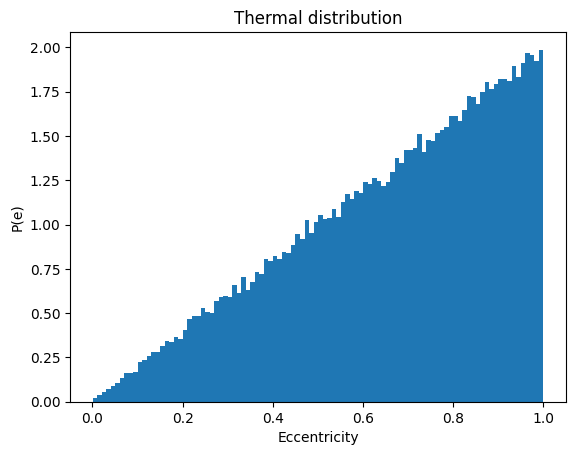

In [17]:
plt.hist([choose_e() for _ in range(100000)], bins=100, density=True);
plt.title("Thermal distribution");
plt.xlabel("Eccentricity");
plt.ylabel("P(e)");

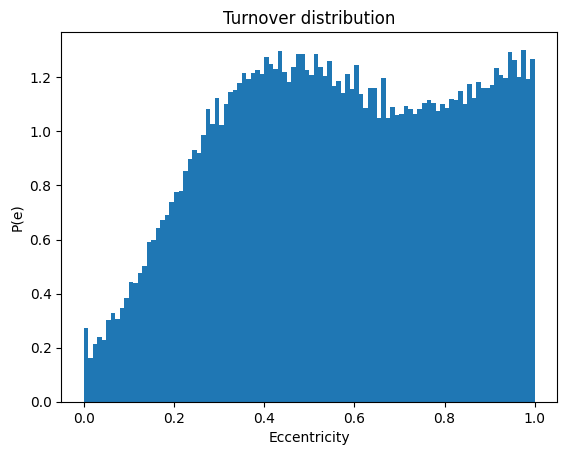

In [25]:
randperiods = np.random.uniform(1,8,100000)

plt.hist([turnover_e(p) for p in randperiods], bins=100, density=True);
plt.title("Turnover distribution");
plt.xlabel("Eccentricity");
plt.ylabel("P(e)");

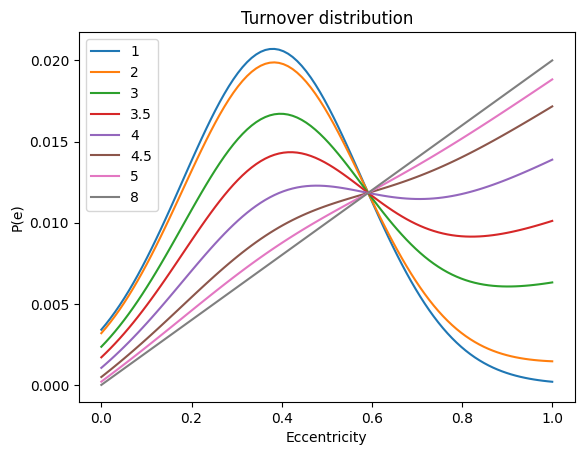

In [19]:
periods = [1,2,3,3.5,4,4.5,5,8]
for p in periods:
    plt.plot(np.linspace(0,1,100), turnover_pdf(np.linspace(0,1,100), p, 3.5, 1), label=p)
plt.legend();
plt.title("Turnover distribution");
plt.xlabel("Eccentricity");
plt.ylabel("P(e)");

## Constraining over different eccentricities

### simple test

Reducing catalogue...
Computing grids...


  0%|          | 0/26010 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/1000 [00:00<?, ?it/s]

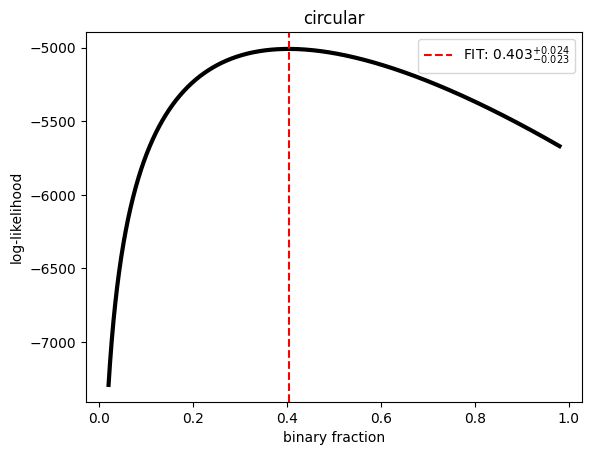

In [5]:
model_cube = Sampler.create_model_cube((15,15))
synthsampler = Sampler.popsampler(sc_cubes_circular, memory_reduced[::10], model_cube=model_cube)
fbs, likelihoods = synthsampler.binarity(resolution=1000)
synthsampler.fb_likelihood(name="circular")

Reducing catalogue...
Computing grids...


  0%|          | 0/26010 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/1000 [00:00<?, ?it/s]

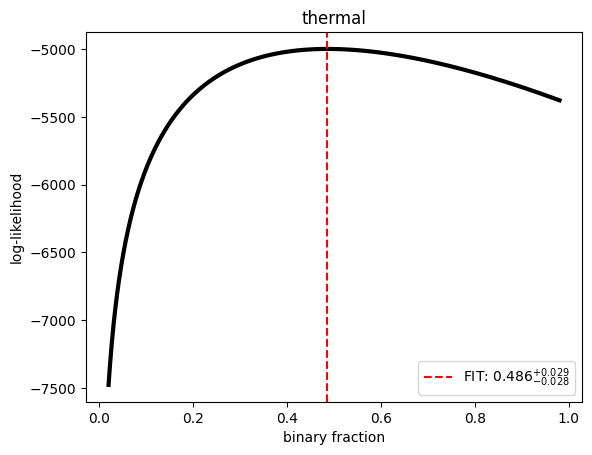

In [6]:
model_cube = Sampler.create_model_cube((15,15))
synthsampler = Sampler.popsampler(sc_cubes_thermal, memory_reduced[::10], model_cube=model_cube)
fbs, likelihoods = synthsampler.binarity(resolution=1000)
synthsampler.fb_likelihood(name="thermal")

Reducing catalogue...
Computing grids...


  0%|          | 0/26010 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/1000 [00:00<?, ?it/s]

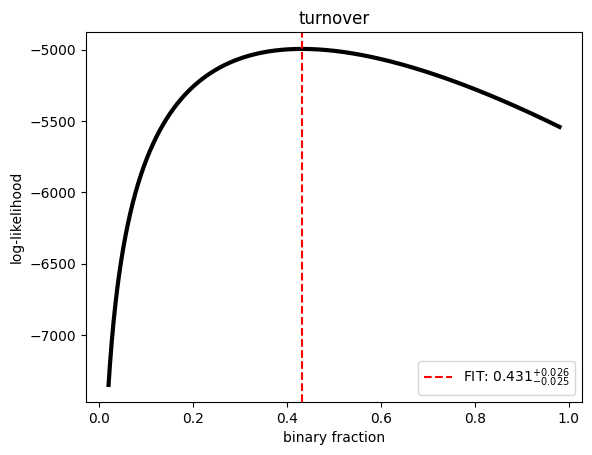

In [7]:
model_cube = Sampler.create_model_cube((15,15))
synthsampler = Sampler.popsampler(sc_cubes_turnover, memory_reduced[::10], model_cube=model_cube)
fbs, likelihoods = synthsampler.binarity(resolution=1000)
synthsampler.fb_likelihood(name="turnover")

naturally, different eccentricity models generate different binary fractions

## A test on synthetic data

In [ ]:
model_cube = Sampler.create_model_cube((15,15), p_model=(4,2))
synthsampler = Sampler.popsampler(sc_cubes_circular, memory_reduced[::10], model_cube=model_cube)
working_catalogue, grids = synthsampler.binarity_precomputations()

  0%|          | 0/26010 [00:00<?, ?it/s]

In [5]:
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
masses = t_loaded["mass_single"]
mass_lims = np.percentile(masses, percentiles)
constraining_results = synthsampler.binarity_binned_mass(model_cube, working_catalogue, grids, mass_lims)

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
model_cube = Sampler.create_model_cube((15,15), p_model=(5,2))
constraining_results_5 = synthsampler.binarity_binned_mass(model_cube, working_catalogue, grids, mass_lims)

  0%|          | 0/10 [00:00<?, ?it/s]

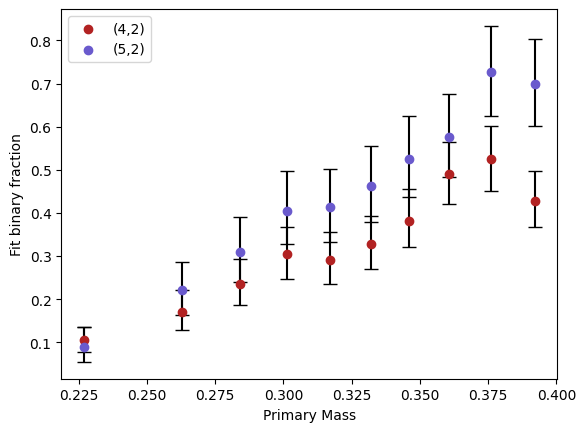

In [8]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) - 5
masses = t_loaded["mass_single"]
mass_lims = np.percentile(masses, percentiles)
plt.errorbar(mass_lims, constraining_results[:,0], yerr=(constraining_results[:,2], constraining_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, constraining_results[:,0], marker='o', color='firebrick', zorder=2, label="(4,2)");

plt.errorbar(mass_lims, constraining_results_5[:,0], yerr=(constraining_results_5[:,2], constraining_results_5[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, constraining_results_5[:,0], marker='o', color='slateblue', zorder=2, label="(5,2)");

plt.xlabel("Primary Mass");
plt.ylabel("Fit binary fraction");
plt.legend();

In [6]:
constraining_results = []
for i, sc_cubes in enumerate([sc_cubes_circular, sc_cubes_thermal, sc_cubes_turnover]):
    model_cube = Sampler.create_model_cube((15,15), p_model=(4,2))
    synthsampler = Sampler.popsampler(sc_cubes, memory_reduced, model_cube=model_cube)
    working_catalogue, grids = synthsampler.binarity_precomputations()
    percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    masses = t_loaded["mass_single"]
    mass_lims = np.percentile(masses, percentiles)
    constraining_results.append(synthsampler.binarity_binned_mass(model_cube, working_catalogue, grids, mass_lims))
    
    model_cube = Sampler.create_model_cube((15,15), p_model=(5,2))
    constraining_results.append(synthsampler.binarity_binned_mass(model_cube, working_catalogue, grids, mass_lims))

  0%|          | 0/260095 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/260095 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/260095 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

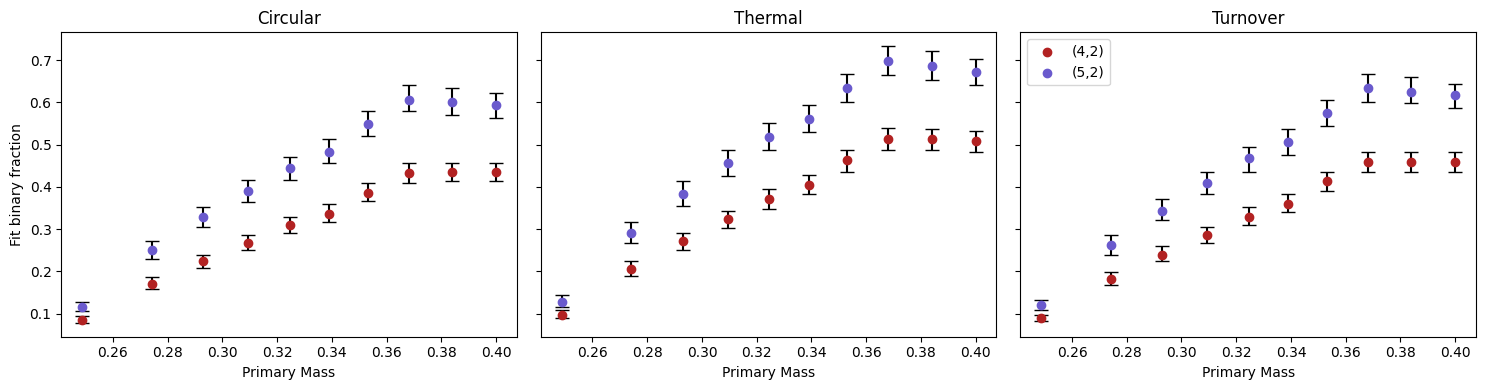

In [48]:
fig, axs = plt.subplots(1,3, figsize=(15,4), sharey=True, sharex=True)

titles = ['Circular', 'Thermal', "Turnover"]
for i in range(3):
    ax = axs[i]
    ax.errorbar(mass_lims, constraining_results[2*i][:,0], yerr=(constraining_results[2*i][:,2], constraining_results[2*i][:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
    ax.scatter(mass_lims, constraining_results[2*i][:,0], marker='o', color='firebrick', zorder=2, label="(4,2)");

    ax.errorbar(mass_lims, constraining_results[2*i+1][:,0], yerr=(constraining_results[2*i+1][:,2], constraining_results[2*i+1][:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
    ax.scatter(mass_lims, constraining_results[2*i+1][:,0], marker='o', color='slateblue', zorder=2, label="(5,2)");

    ax.set_xlabel("Primary Mass");
    ax.set_title(titles[i])
axs[0].set_ylabel("Fit binary fraction");
axs[2].legend();
plt.tight_layout()

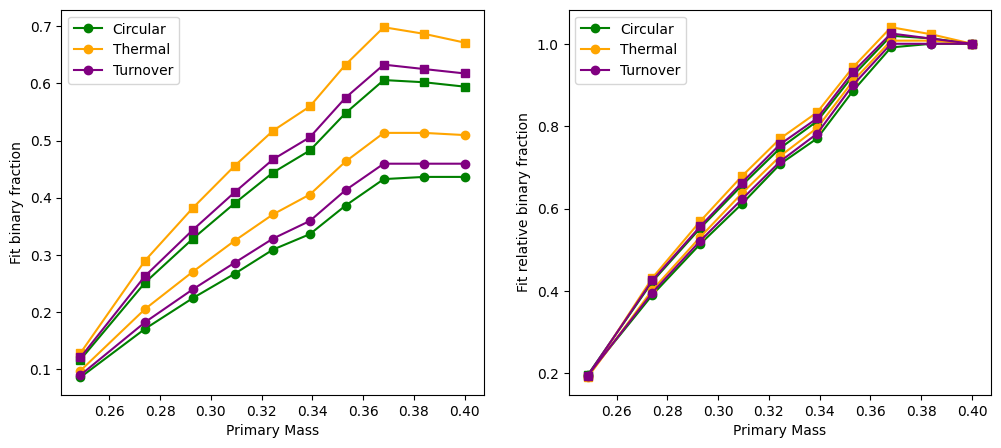

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

colors = ["green", "orange", "purple"]
titles = ['Circular', 'Thermal', "Turnover"]
ax = axs[0]
for i in range(3):
    ax.plot(mass_lims, constraining_results[2*i][:,0], marker='o', color=colors[i], zorder=2, label=titles[i]); # (4,2)
    ax.plot(mass_lims, constraining_results[2*i+1][:,0], marker='s', color=colors[i], zorder=2); # (5,2)
ax.set_xlabel("Primary Mass");
ax.set_ylabel("Fit binary fraction");
ax.legend();
    
ax = axs[1]
for i in range(3):
    ax.plot(mass_lims, constraining_results[2*i][:,0]/constraining_results[2*i][-1,0], marker='o', color=colors[i], zorder=2, label=titles[i]);
    ax.plot(mass_lims, constraining_results[2*i+1][:,0]/constraining_results[2*i+1][-1,0], marker='s', color=colors[i], zorder=2);
ax.set_xlabel("Primary Mass");
ax.set_ylabel("Fit relative binary fraction");
ax.legend();

In [22]:
counts = np.zeros((len(mass_lims), 3))
for i in tqdm(range(len(mass_lims))):
    for j, obj in enumerate(working_catalogue):
        obj["solution_type"] = [0,5,7,9,12][obj["soltype_index"]]
        use_obj = False
        if i == 0:
            if obj["mass"] < mass_lims[0]:
                use_obj = True
        else:
            if (mass_lims[i-1] < obj["mass"]) & (obj["mass"] < mass_lims[i]):
                use_obj = True
        
        if use_obj:
            if obj["solution_type"] == 0:
                counts[i,0] += 1
            elif obj["solution_type"] == 5:
                counts[i,1] += 1
            else:
                counts[i,2] += 1

  0%|          | 0/10 [00:00<?, ?it/s]

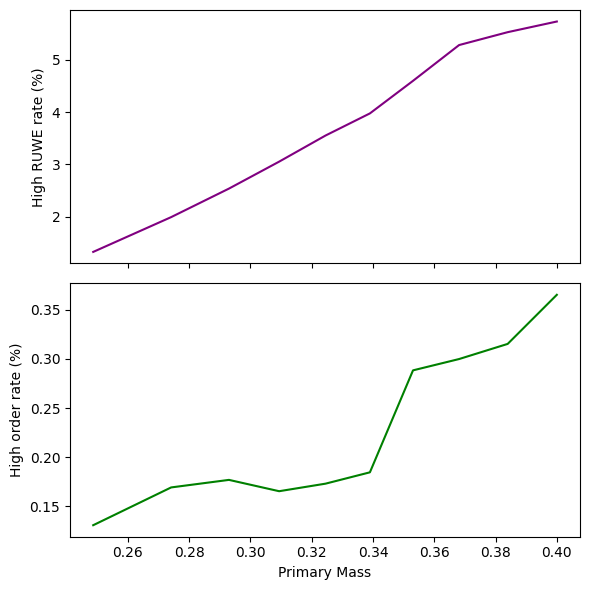

In [40]:
fig, axs = plt.subplots(2,1, figsize=(6,6), sharex=True)
axs[0].plot(mass_lims, 100*counts[:,1]/np.sum(counts, axis=1), color="purple");
axs[0].set_ylabel("High RUWE rate (%)");
axs[1].plot(mass_lims, 100*counts[:,2]/np.sum(counts, axis=1), color="green");
axs[1].set_ylabel("High order rate (%)");
axs[1].set_xlabel("Primary Mass");
plt.tight_layout()

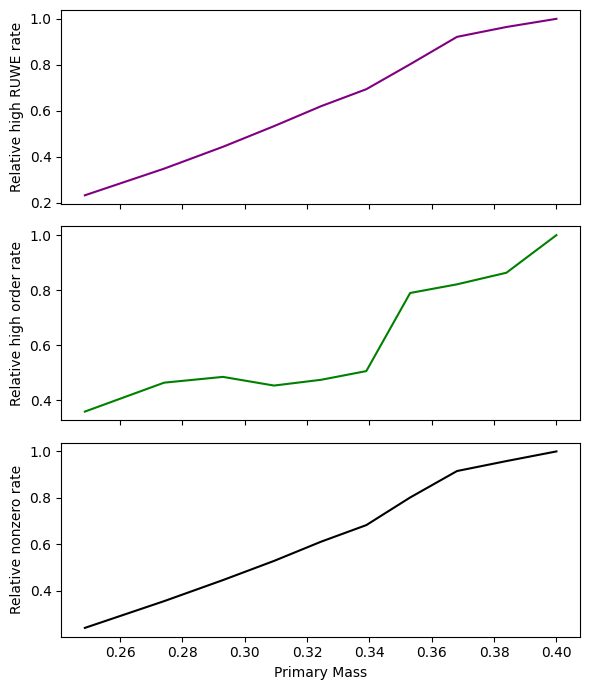

In [45]:
fig, axs = plt.subplots(3,1, figsize=(6,7), sharex=True)
rates = 100*counts[:,1]/np.sum(counts, axis=1)
axs[0].plot(mass_lims, rates/rates[-1], color="purple");
axs[0].set_ylabel("Relative high RUWE rate");
rates = 100*counts[:,2]/np.sum(counts, axis=1)
axs[1].plot(mass_lims, rates/rates[-1], color="green");
axs[1].set_ylabel("Relative high order rate");
rates = 100*(counts[:,1]+counts[:,2])/np.sum(counts, axis=1)
axs[2].plot(mass_lims, rates/rates[-1], color="black");
axs[2].set_ylabel("Relative nonzero rate");
axs[2].set_xlabel("Primary Mass");
plt.tight_layout()